# Test CLUE performance

In this notebook, we test CLUE's performance for 3 different setups of a Bayesian last-layer MNIST classifier. 

We allow a choice between:
- Classifier dominated backbone 
- Joint training backbone
- Autoencoder dominated backbone

## Setup


In [1]:
inDrive = False

In [2]:
if inDrive:
    from google.colab import drive
    drive.mount('/content/drive')
    import os
    os.chdir('/content/drive/My Drive/Hybrid-CLUE/MyImplementation/testing_notebooks')
    import sys

    # Add the parent directory to the system path
    current_dir = os.getcwd()
    parent_dir = os.path.dirname(current_dir)
    sys.path.insert(0, parent_dir)

Import libraries

In [3]:
import importlib
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os

import models.BLL
import models.mnist_classifier_BLL
import train
import sampler
import models.regene_models


Set the configuration

In [4]:
# 1. Configuration
class Config:
    # Data
    batch_size = 512
    latent_dim = 256

    # Hardware
    device = 'cuda' if torch.cuda.is_available() \
    else 'mps' if torch.backends.mps.is_available() \
    else 'cpu'

cfg = Config()

In [5]:
models_dir = '../model_saves/new_regene_models'
results_dir = '../results/new_regene_models'
os.makedirs(models_dir, exist_ok=True)
os.makedirs(results_dir, exist_ok=True)

## Backbone
We'll start with the backbone loading. Options are either classifier_dominated, joint_training, or autoencoder_dominated.

In [6]:
classifier_dominated = False
joint_training = True
autoencoder_dominated = False

### Load chosen model

Load model

In [7]:
importlib.reload(models.regene_models)

decoder = models.regene_models.Decoder(latent_dim=cfg.latent_dim, device=cfg.device)
backbone = models.regene_models.Classifier(latent_dim=cfg.latent_dim, num_classes=10, device=cfg.device)

if classifier_dominated:
    backbone.load(models_dir + '/classifier_dominated_classifier_256.pt')
    decoder.load(models_dir + '/classifier_dominated_decoder_256.pt')
    name = 'classifier_dominated'
    bll_name = 'BLL_VI_classifier_dominated_first_256.pt'
elif joint_training:
    backbone.load(os.path.join(models_dir, 'joint_classifier_256.pt'))
    decoder.load(os.path.join(models_dir, 'joint_decoder_256.pt'))
    name = 'joint_training'
    bll_name = 'BLL_VI_joint_training_first_256.pt'
elif autoencoder_dominated:
    backbone.load(models_dir + '/autoencoder_dominated_classifier_full_256.pt')
    decoder.load(models_dir + '/autoencoder_dominated_decoder_256.pt')
    name = 'autoencoder_dominated'
    bll_name = 'BLL_VI_autoencoder_dominated_first_256.pt'

Loaded classifier model from: ../model_saves/new_regene_models/joint_classifier_256.pt
Loaded decoder model from: ../model_saves/new_regene_models/joint_decoder_256.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/regene_models.py:113: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.lo

Load the Datasets

In [8]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='../data', train=False, download=True, transform=transform)

# Split training set into train and validation
train_size = int(0.8 * len(trainset))
val_size = len(trainset) - train_size
trainset, valset = torch.utils.data.random_split(trainset, [train_size, val_size])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=cfg.batch_size, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(valset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=cfg.batch_size, shuffle=False, num_workers=2)

Create a models and results directory if it doesn't exist

## Bayesian Last Layer - VI
Next we'll train a variational inference version of the Bayesian last layer using the chosen backbone.


In [9]:
if inDrive: 
    %pip install torchbnn

### Load the model

In [10]:
from models.BLL_VI import BayesianLastLayerVI
importlib.reload(models.BLL_VI)

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

bll_vi = BayesianLastLayerVI(
    backbone=backbone,
    input_dim=cfg.latent_dim,  # Matches backbone's encoder output
    output_dim=10,  # MNIST classes
    device=cfg.device
)

# Verify all model components are on the correct device
print(f"Backbone device: {next(bll_vi.backbone.parameters()).device}")
print(f"Last layer device: {next(bll_vi.last_layer.parameters()).device}")

bll_vi.load_checkpoint(os.path.join(models_dir, bll_name))

Backbone device: mps:0
Last layer device: mps:0
 [load_checkpoint] Loaded checkpoint from ../model_saves/new_regene_models/BLL_VI_joint_training_first_256.pt


/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/models/BLL_VI.py:143: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = t

### Test the model
To check for Bayesian behaviour, we find an uncertain prediction and visualize multiple samples from the posterior.


Could not find uncertain prediction in entire test set


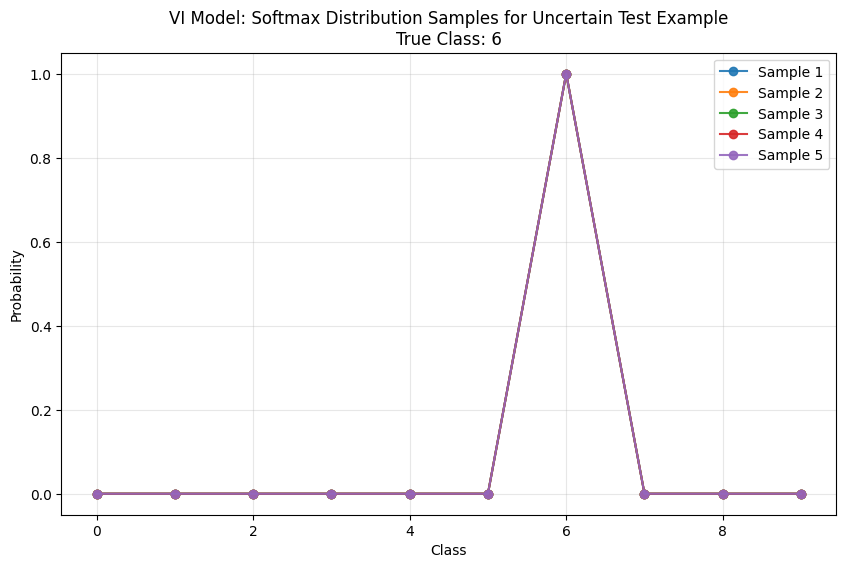

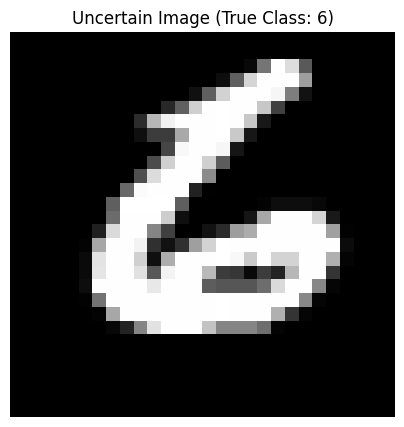

In [11]:
import torch.nn.functional as F

# Search for an uncertain prediction and visualize multiple samples
test_iter = iter(testloader)
found_uncertain = False
max_tries = 100
num_samples = 5

try:
    while not found_uncertain:
        x, y = next(test_iter)
        # Look at each example in the batch
        for i in range(len(x)):
            x_single = x[i:i+1]
            y_single = y[i:i+1]

            # Get multiple predictions for this single example
            outputs = []
            with torch.no_grad():  # Add no_grad context
                for _ in range(num_samples):
                    logits = bll_vi(x_single)
                    probs = F.softmax(logits, dim=1)
                    outputs.append(probs)

            # Stack predictions
            probs = torch.stack(outputs)  # Shape: [num_samples, 1, num_classes]
            probs = probs.squeeze(1)  # Remove batch dimension -> [num_samples, num_classes]

            # Check if predictions are not all highly confident
            max_probs = probs.max(dim=1)[0]
            if max_probs.mean() < 0.7:  # If average confidence is less than 60%
                found_uncertain = True
                break

except StopIteration:
    if not found_uncertain:
        print("Could not find uncertain prediction in entire test set")

# Plot the softmax distributions
plt.figure(figsize=(10, 6))
x_axis = range(probs.shape[1])  # Range over number of classes

for i in range(num_samples):
    plt.plot(x_axis, probs[i].detach().cpu().numpy(), 'o-', alpha=0.9, label=f'Sample {i+1}')

plt.xlabel('Class')
plt.ylabel('Probability')
plt.title(f'VI Model: Softmax Distribution Samples for Uncertain Test Example\nTrue Class: {y_single.item()}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Display the uncertain image
plt.figure(figsize=(5, 5))
img = x_single.squeeze().cpu()
if img.shape[0] == 1:  # If grayscale, remove channel dimension
    img = img.squeeze(0)
plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
plt.axis('off')
plt.title(f'Uncertain Image (True Class: {y_single.item()})')
plt.show()

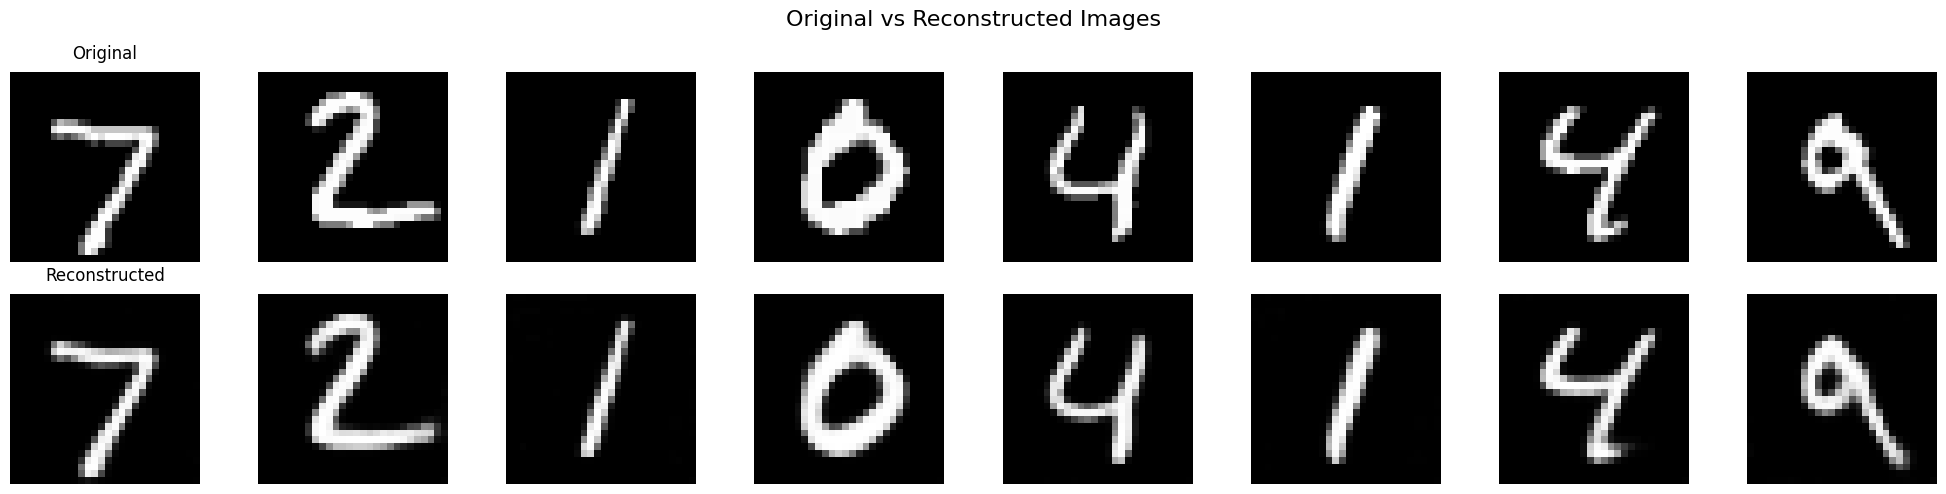

Reconstruction MSE: 0.0035


In [12]:
# Get test images
test_images, test_labels = next(iter(testloader))
test_images = test_images.to(cfg.device)

# Get reconstructions using the classifier and decoder
with torch.no_grad():
    # Get latent representations from classifier
    latent_reps, _ = backbone(test_images)  # Returns (latent_rep, logits)
    # Reconstruct using decoder
    reconstructions = decoder(latent_reps)

# Plot original and reconstructed images
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
fig.suptitle('Original vs Reconstructed Images', fontsize=16)

# Plot original images
for i in range(8):
    axes[0,i].imshow(test_images[i].cpu().squeeze(), cmap='gray')
    axes[0,i].axis('off')
    if i == 0:
        axes[0,i].set_title('Original', pad=10)

# Plot reconstructions
for i in range(8):
    axes[1,i].imshow(reconstructions[i].cpu().squeeze(), cmap='gray')
    axes[1,i].axis('off')
    if i == 0:
        axes[1,i].set_title('Reconstructed', pad=10)

plt.tight_layout()
plt.show()

# Optionally, calculate reconstruction error
mse = nn.MSELoss()
recon_error = mse(reconstructions, test_images)
print(f'Reconstruction MSE: {recon_error.item():.4f}')

## Evaluate CLUE

### Load the VAE

In [13]:
from models.VAE_likelihood import ConvVAELikelihoodEstimator

vae = ConvVAELikelihoodEstimator(latent_dim=20, device=cfg.device)

vae.load_state_dict(torch.load(os.path.join(models_dir, 'vae_likelihood_estimator_20.pt'), map_location=cfg.device))


/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_93249/344240935.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(os.path.join(mo

<All keys matched successfully>

### Get Uncertain Images

In [14]:
import importlib
import clue.evaluate_CLUE
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import evaluate_clue_counterfactuals, find_uncertain_images, visualize_counterfactual_results, evaluate_single_clue_counterfactual

In [15]:
uncertain_images, uncertain_indices = find_uncertain_images(bll_vi, testloader, n=50, device=cfg.device)

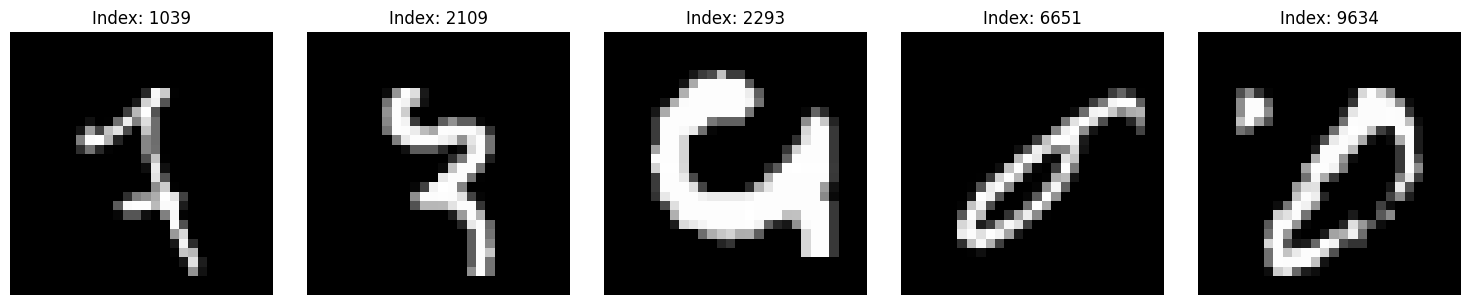

Uncertainty indices of these images: [1039, 2109, 2293, 6651, 9634]


In [16]:
# Plot the first 5 uncertain images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(uncertain_images[i, 0].cpu(), cmap='gray')
    plt.title(f"Index: {uncertain_indices[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Uncertainty indices of these images:", uncertain_indices[:5].tolist())

### Test a single image

Step 00: Loss: 2.7805, Target Class Logit: -2.7805, Target Class Prob: 0.0033, Distance: 0.0000
Step 01: Loss: 3.0794, Target Class Logit: -1.4794, Target Class Prob: 0.0115, Distance: 1.6000
Step 02: Loss: 2.7433, Target Class Logit: -0.7018, Target Class Prob: 0.0231, Distance: 2.0415
Step 03: Loss: 2.6399, Target Class Logit: -0.1660, Target Class Prob: 0.0365, Distance: 2.4739
Step 04: Loss: 2.6033, Target Class Logit: 0.2720, Target Class Prob: 0.0523, Distance: 2.8753
Step 05: Loss: 2.5333, Target Class Logit: 0.6845, Target Class Prob: 0.0732, Distance: 3.2178
Step 06: Loss: 2.4390, Target Class Logit: 1.0953, Target Class Prob: 0.1021, Distance: 3.5343
Step 07: Loss: 2.3498, Target Class Logit: 1.5099, Target Class Prob: 0.1421, Distance: 3.8597
Step 08: Loss: 2.2811, Target Class Logit: 1.9277, Target Class Prob: 0.1959, Distance: 4.2088
Step 09: Loss: 2.2314, Target Class Logit: 2.3459, Target Class Prob: 0.2649, Distance: 4.5774
Step 10: Loss: 2.1909, Target Class Logit: 2.7

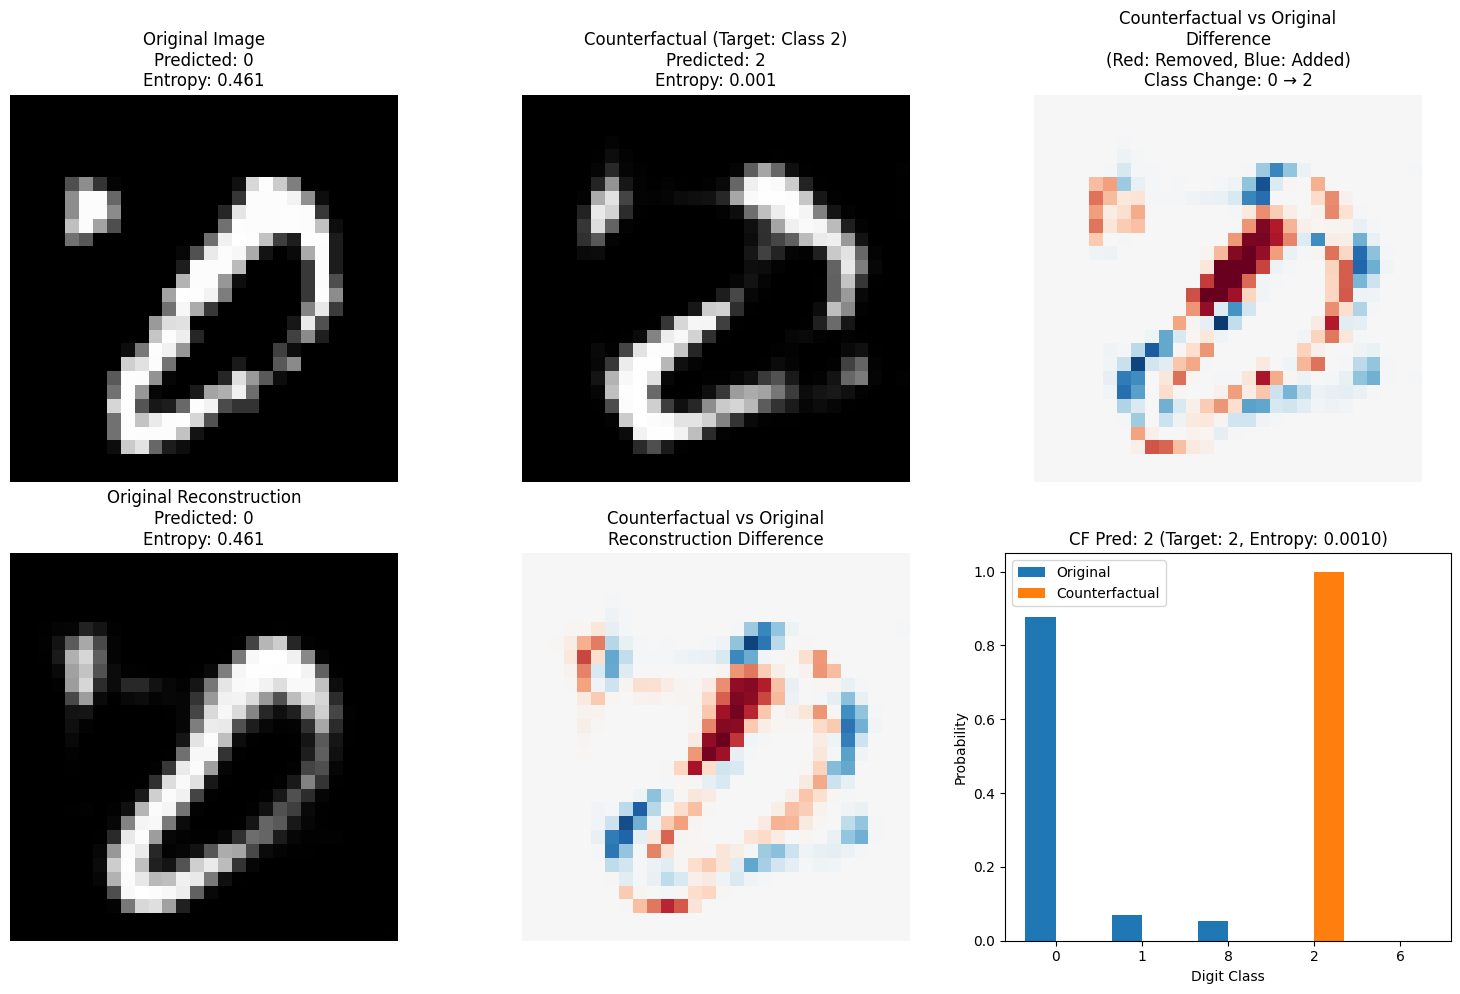


CLUE Counterfactual Results:
Latent Distance: 94.091
Latent Entropy Reduction: 0.225
Reconstruction Entropy Reduction: 0.459

Class probabilities:
Original (Predicted: 0): [0.876 0.07  0.    0.    0.    0.    0.    0.    0.054 0.   ]
Counterfactual (Predicted: 2, Target: 2): [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]

Likelihood metrics:
Original log-likelihood: -183.06
Reconstruction log-likelihood: -209.13
Counterfactual log-likelihood: -225.99
Log-likelihood difference (original vs CF): 42.93
Log-likelihood difference (recon vs CF): 16.85
Likelihood ratio (CF/original): 0.00x
Likelihood ratio (CF/recon): 0.00x
Original realism score: 0.900
Reconstruction realism score: 0.864
Counterfactual realism score: 0.800
Realism score difference (original vs CF): 0.099
Realism score difference (recon vs CF): 0.064


In [23]:
import clue.new_CLUE
importlib.reload(clue.new_CLUE)

results, figure = evaluate_single_clue_counterfactual(
    uncertain_images[4],
    backbone,
    decoder,
    vae,
    device=cfg.device,
    verbose=True,
    steps=200,
    distance_weight=1,
    lr=0.1,
    target_class=2,
    bayesian=False
)

### Get average metrics

In [ ]:
results = evaluate_clue_counterfactuals(
    uncertain_images[10:20],
    bll_vi,
    decoder,
    vae,
    device=cfg.device,
    steps=200,
    lr=0.05,
    distance_weight=0.005,
)

KeyboardInterrupt: 


Aggregate Results over 10 images:
Average latent entropy reduction: 1.360
Average reconstruction entropy reduction: 0.739
Average latent distance: 25.202
Average log likelihood difference: 9.543
Average realism score difference: 0.003


Example 1 (Image Index: 7):
Latent entropy reduction: 1.583
Latent distance: 31.666
Log likelihood difference: -14.819
Original class prediction: 9
Counterfactual class prediction: 9

Example 2 (Image Index: 2):
Latent entropy reduction: 1.475
Latent distance: 30.338
Log likelihood difference: 4.699
Original class prediction: 1
Counterfactual class prediction: 1

Example 3 (Image Index: 8):
Latent entropy reduction: 1.414
Latent distance: 25.127
Log likelihood difference: 20.361
Original class prediction: 9
Counterfactual class prediction: 9

Example 4 (Image Index: 1):
Latent entropy reduction: 1.394
Latent distance: 20.476
Log likelihood difference: 26.466
Original class prediction: 5
Counterfactual class prediction: 5

Example 5 (Image Index: 9):
La

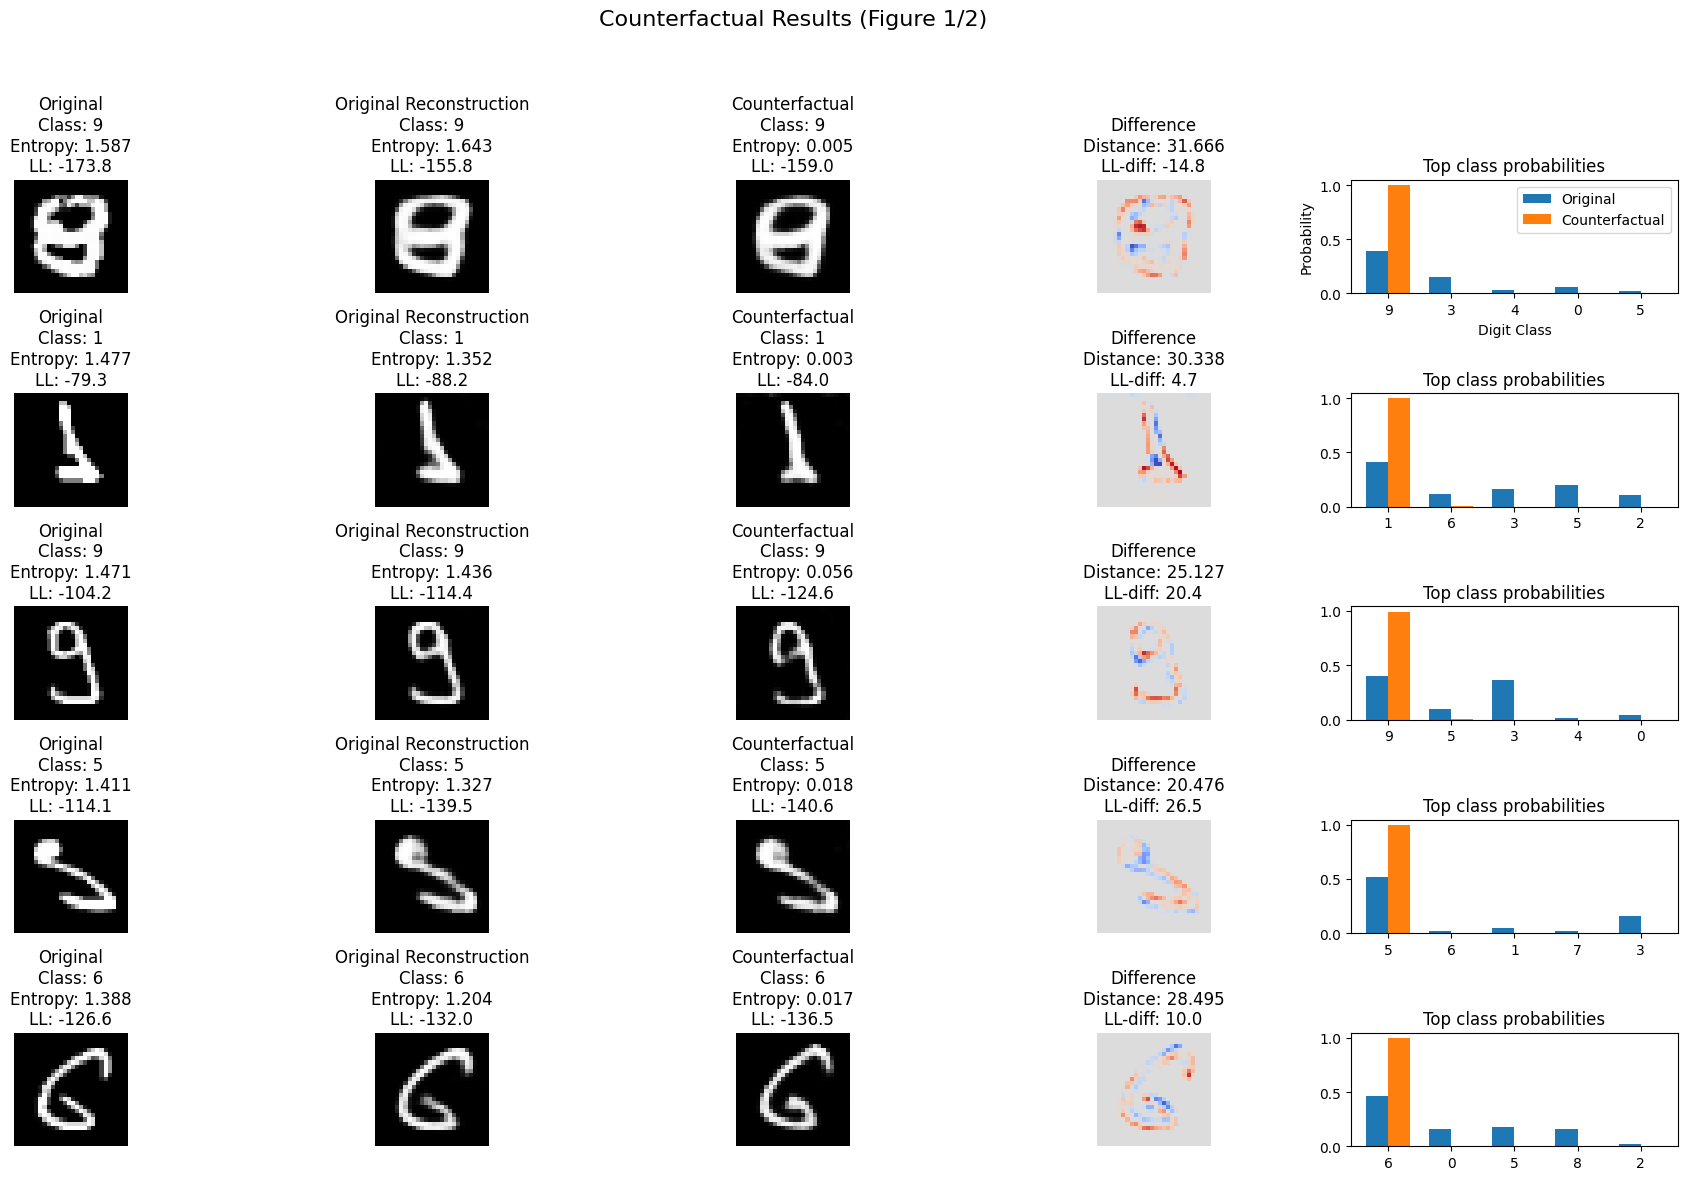

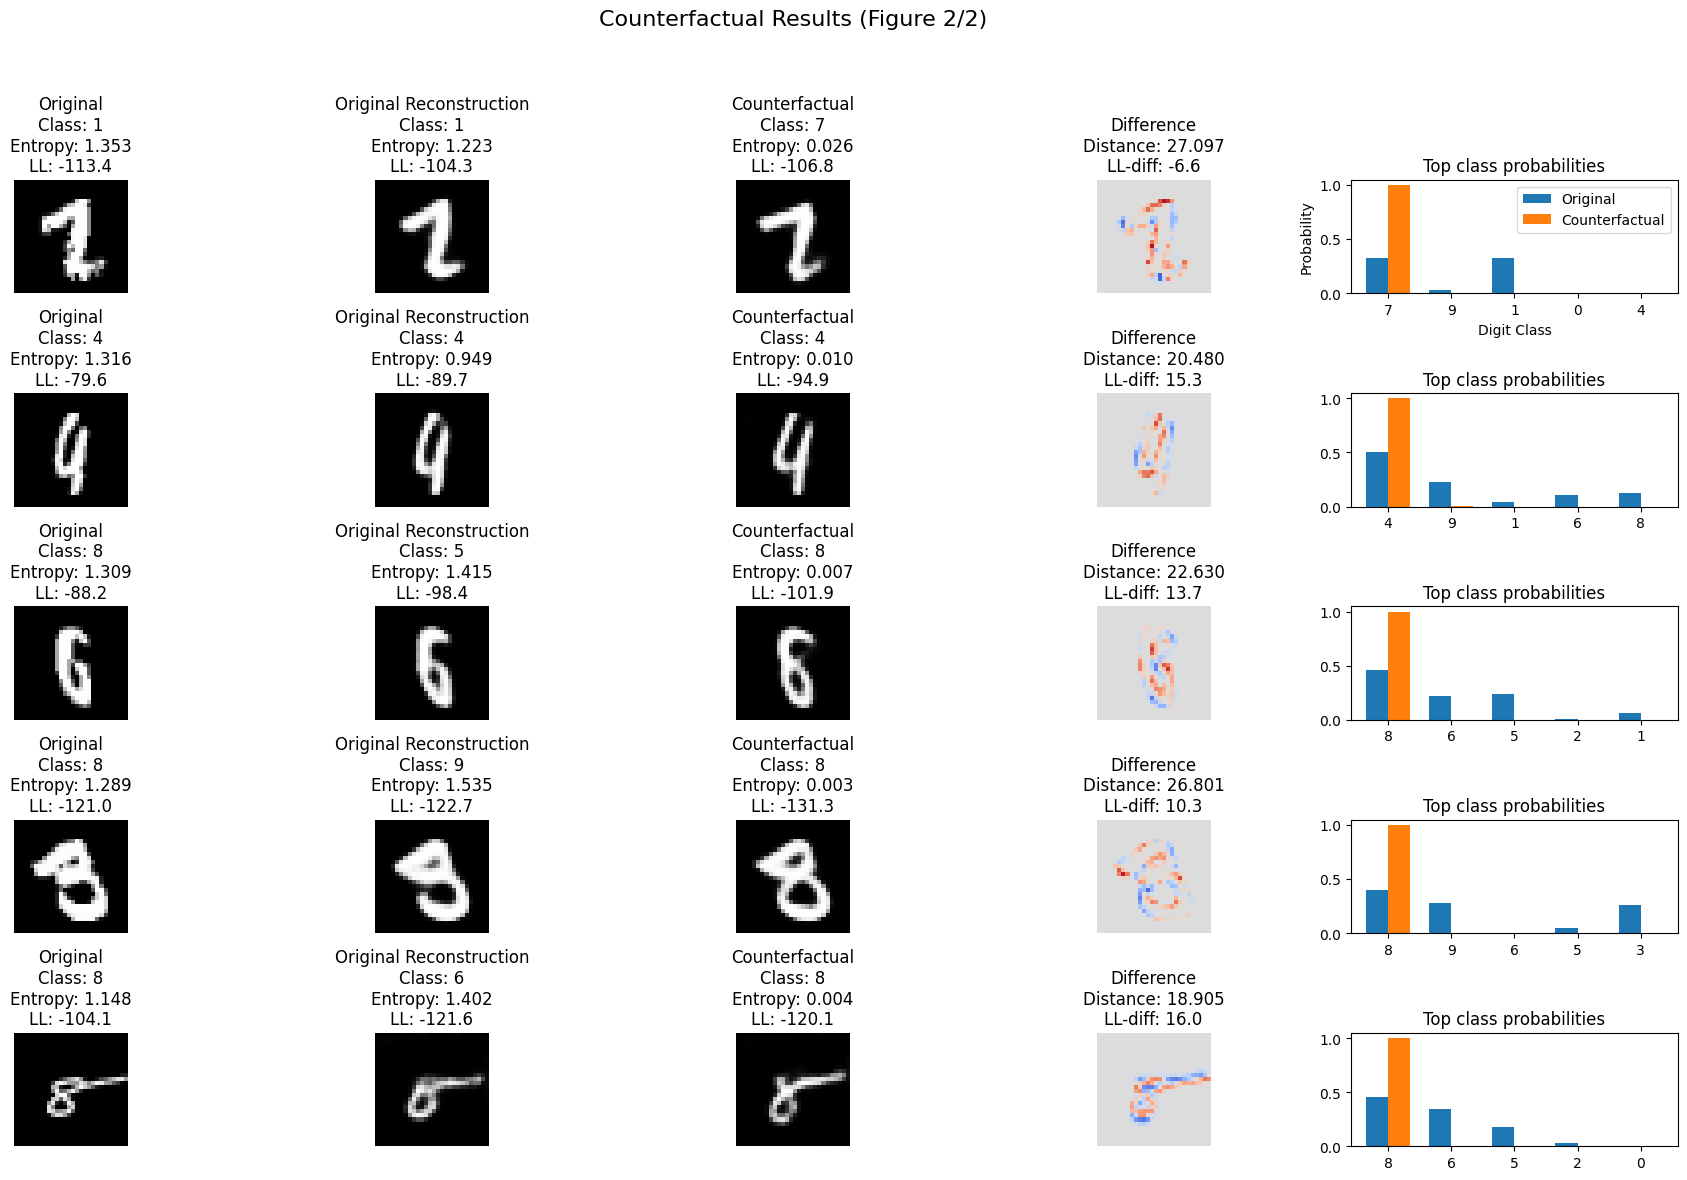

In [ ]:
visualize_counterfactual_results(results, n=10)

In [ ]:
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import save_counterfactual_results_to_csv

results_directory= models_dir + '/CLUE_results'

save_counterfactual_results_to_csv(results, output_dir=results_directory, suffix='joint_model_256_few_samples')

Individual results saved to: ../model_saves/new_regene_models/CLUE_results/joint_model_256_few_samples_2025-03-08_11-44-58/individual_results.csv
Aggregate results saved to: ../model_saves/new_regene_models/CLUE_results/joint_model_256_few_samples_2025-03-08_11-44-58/aggregate_results.csv


('../model_saves/new_regene_models/CLUE_results/joint_model_256_few_samples_2025-03-08_11-44-58/individual_results.csv',
 '../model_saves/new_regene_models/CLUE_results/joint_model_256_few_samples_2025-03-08_11-44-58/aggregate_results.csv')

## Evaluate CLUE (Deterministic)

### Load the VAE

In [133]:
from models.VAE_likelihood import ConvVAELikelihoodEstimator

vae = ConvVAELikelihoodEstimator(latent_dim=20, device=cfg.device)

vae.load_state_dict(torch.load(os.path.join(models_dir, 'vae_likelihood_estimator_20.pt'), map_location=cfg.device))


/var/folders/tb/ccwl9r592hn9v_xpq9s1bzlr0000gn/T/ipykernel_56791/344240935.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(os.path.join(mo

<All keys matched successfully>

### Get Uncertain Images

In [134]:
import importlib
import clue.evaluate_CLUE
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import evaluate_clue_counterfactuals, find_uncertain_images, visualize_counterfactual_results, evaluate_single_clue_counterfactual

In [115]:
uncertain_images, uncertain_indices = find_uncertain_images(backbone, testloader, n=50, device=cfg.device, bayesian=False)

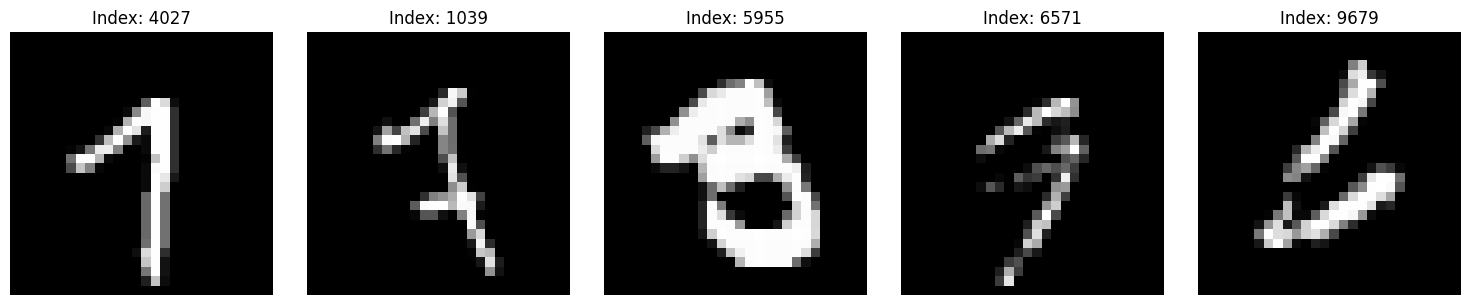

Uncertainty indices of these images: [4027, 1039, 5955, 6571, 9679]


In [135]:
# Plot the first 5 uncertain images
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(uncertain_images[i, 0].cpu(), cmap='gray')
    plt.title(f"Index: {uncertain_indices[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

print("Uncertainty indices of these images:", uncertain_indices[:5].tolist())

### Test a single image

Step 00: Loss: 0.4461, Total Entropy: 0.4461, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.4461, Distance: 0.0000
Step 01: Loss: 0.2758, Total Entropy: 0.2718, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.2718, Distance: 0.8000
Step 02: Loss: 0.1695, Total Entropy: 0.1617, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.1617, Distance: 1.5629
Step 03: Loss: 0.1083, Total Entropy: 0.0969, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0969, Distance: 2.2772
Step 04: Loss: 0.0743, Total Entropy: 0.0597, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0597, Distance: 2.9321
Step 05: Loss: 0.0557, Total Entropy: 0.0380, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0380, Distance: 3.5239
Step 06: Loss: 0.0455, Total Entropy: 0.0252, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0252, Distance: 4.0540
Step 07: Loss: 0.0400, Total Entropy: 0.0173, Epistemic Entropy: 0.0000, Aleatoric Entropy: 0.0173, Distance: 4.5261
Step 08: Loss: 0.0371, Total Entropy: 0.0124, Epistemic Entropy:

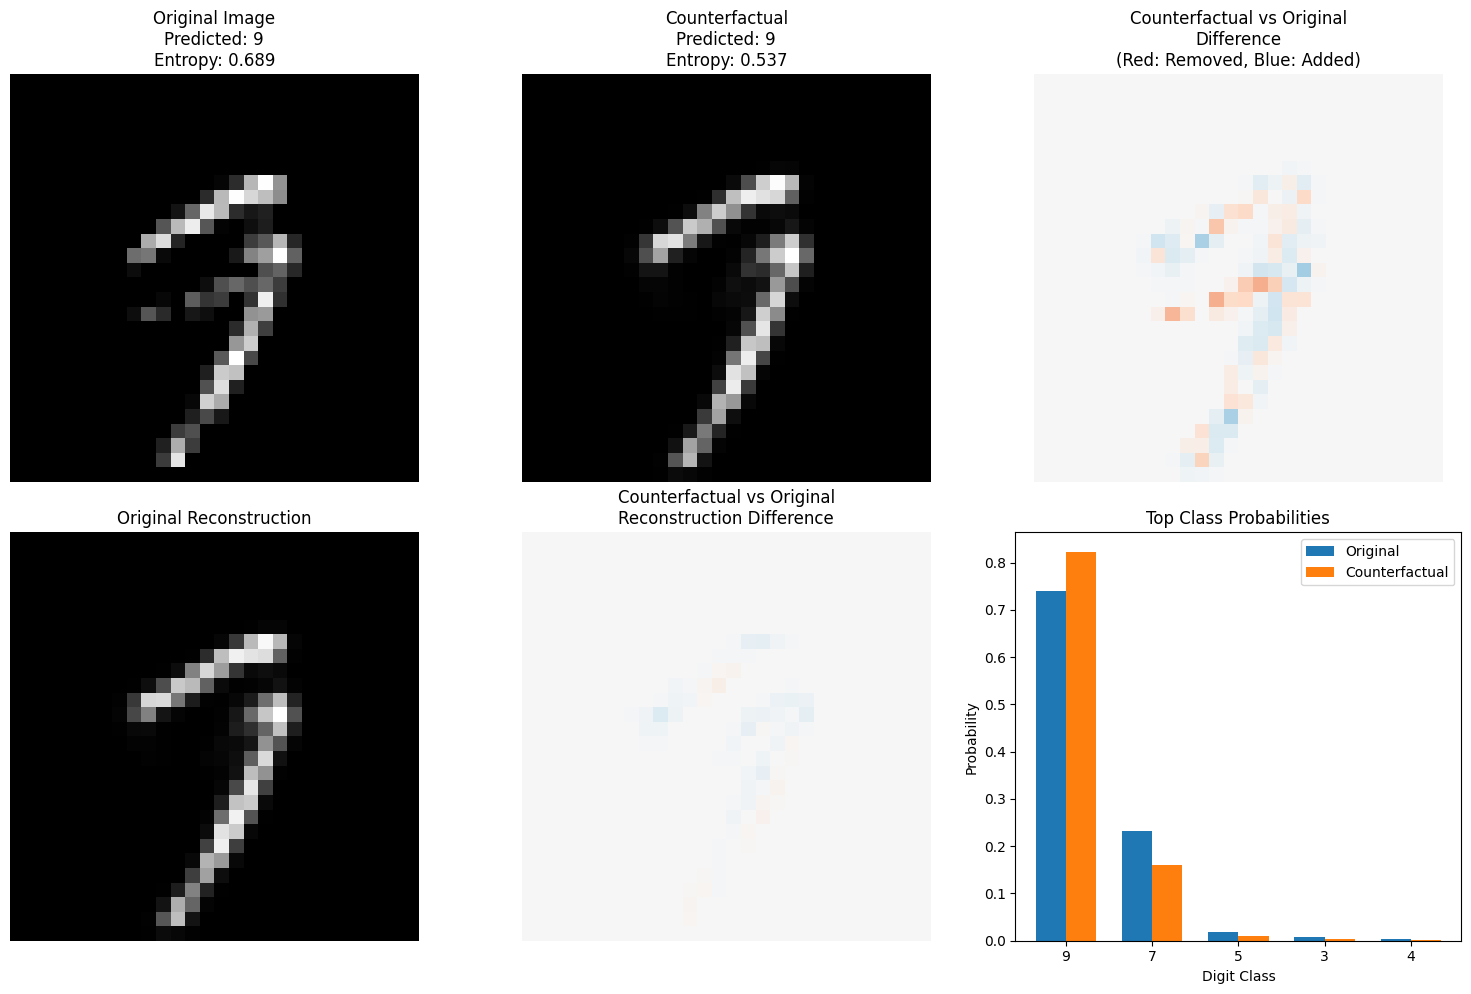


CLUE Counterfactual Results:
Latent Distance: 4.590
Latent Entropy Reduction: 0.441
Reconstruction Entropy Reduction: 0.152

Class probabilities:
Original (Predicted: 9): [0.    0.    0.    0.008 0.003 0.018 0.    0.231 0.    0.74 ]
Counterfactual (Predicted: 9): [0.    0.    0.    0.004 0.002 0.01  0.    0.161 0.    0.823]

Likelihood metrics:
Original log-likelihood: -85.17
Counterfactual log-likelihood: -84.48
Log-likelihood difference: -0.69
Likelihood ratio: 2.00x more likely
Original realism score: 0.987
Counterfactual realism score: 0.987
Realism score difference: -0.000


In [136]:
results, figure = evaluate_single_clue_counterfactual(
    uncertain_images[3],
    backbone,
    decoder,
    vae,
    device=cfg.device,
    verbose=True,
    steps=200,
    distance_weight=0.005,
    lr=0.05,
    bayesian=False
)

### Get average metrics

In [137]:
results = evaluate_clue_counterfactuals(
    uncertain_images,
    backbone,
    decoder,
    vae,
    device=cfg.device,
    steps=200,
    lr=0.05,
    distance_weight=0.005,
    bayesian=False
)


Aggregate Results over 50 images:
Average latent entropy reduction: 0.691
Average reconstruction entropy reduction: 0.225
Average latent distance: 4.789
Average log likelihood difference: 3.419
Average realism score difference: 0.001


Example 1 (Image Index: 10):
Latent entropy reduction: 1.406
Latent distance: 6.549
Log likelihood difference: 1.142
Original class prediction: 9
Counterfactual class prediction: 9

Example 2 (Image Index: 21):
Latent entropy reduction: 1.363
Latent distance: 5.727
Log likelihood difference: 4.273
Original class prediction: 4
Counterfactual class prediction: 4

Example 3 (Image Index: 44):
Latent entropy reduction: 1.309
Latent distance: 5.510
Log likelihood difference: 2.906
Original class prediction: 1
Counterfactual class prediction: 1

Example 4 (Image Index: 1):
Latent entropy reduction: 1.272
Latent distance: 6.221
Log likelihood difference: 3.992
Original class prediction: 9
Counterfactual class prediction: 9

Example 5 (Image Index: 16):
Latent 

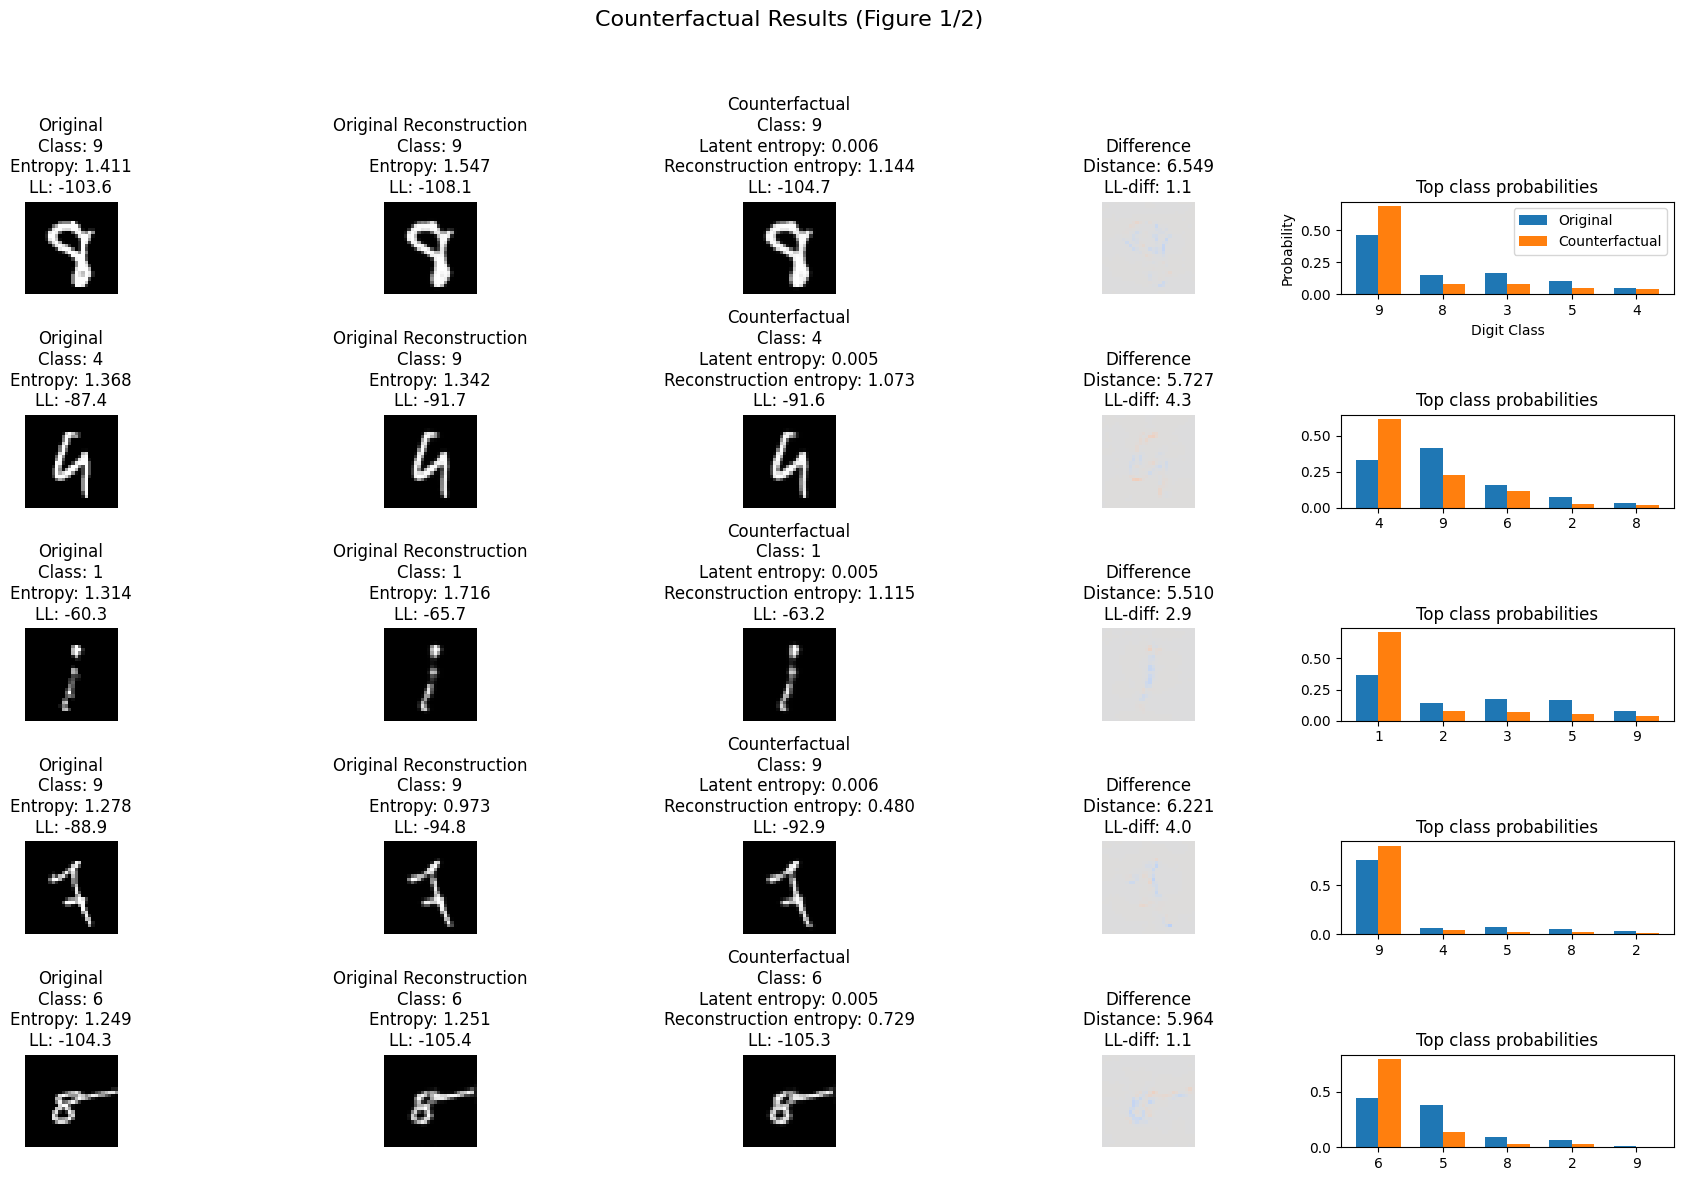

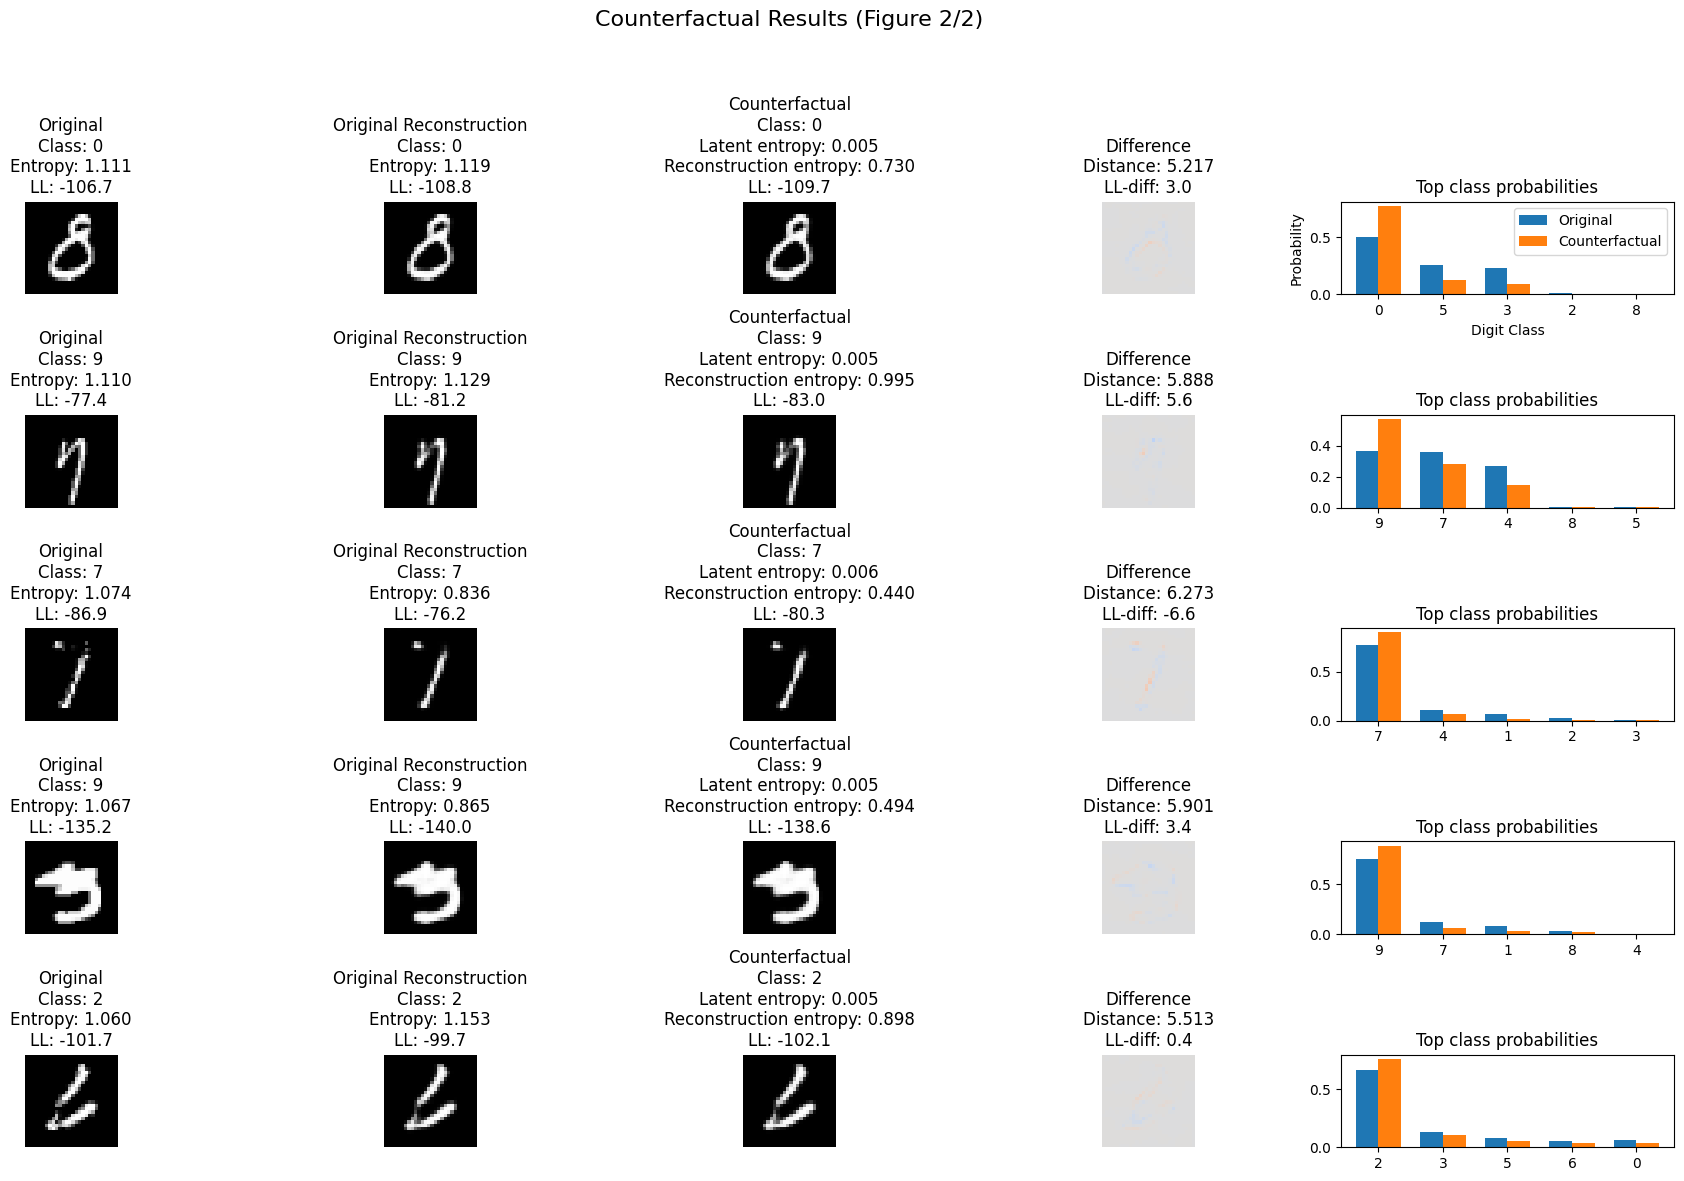

In [138]:
visualize_counterfactual_results(results, n=10)

In [139]:
importlib.reload(clue.evaluate_CLUE)
from clue.evaluate_CLUE import save_counterfactual_results_to_csv

results_directory= models_dir + '/CLUE_results'

save_counterfactual_results_to_csv(results, output_dir=results_directory, suffix='DETERMINISTIC_autoencoder_dominated_model_256_50_samples')

Individual results saved to: ../model_saves/new_regene_models/CLUE_results/DETERMINISTIC_autoencoder_dominated_model_256_50_samples_2025-03-08_12-45-41/individual_results.csv
Aggregate results saved to: ../model_saves/new_regene_models/CLUE_results/DETERMINISTIC_autoencoder_dominated_model_256_50_samples_2025-03-08_12-45-41/aggregate_results.csv


('../model_saves/new_regene_models/CLUE_results/DETERMINISTIC_autoencoder_dominated_model_256_50_samples_2025-03-08_12-45-41/individual_results.csv',
 '../model_saves/new_regene_models/CLUE_results/DETERMINISTIC_autoencoder_dominated_model_256_50_samples_2025-03-08_12-45-41/aggregate_results.csv')

## Test Counterfactual - Specify Class

Test a single image

Step 00: Loss: 1.1230, Total Entropy: 1.1230, Epistemic Entropy: 0.9564, Aleatoric Entropy: 0.1665, Distance: 0.0000
Step 01: Loss: 1.1842, Total Entropy: 1.1802, Epistemic Entropy: 1.0127, Aleatoric Entropy: 0.1675, Distance: 0.8000
Step 02: Loss: 1.0185, Total Entropy: 1.0117, Epistemic Entropy: 0.8685, Aleatoric Entropy: 0.1432, Distance: 1.3549
Step 03: Loss: 0.9202, Total Entropy: 0.9111, Epistemic Entropy: 0.7627, Aleatoric Entropy: 0.1483, Distance: 1.8216
Step 04: Loss: 1.1790, Total Entropy: 1.1676, Epistemic Entropy: 0.9657, Aleatoric Entropy: 0.2018, Distance: 2.2826
Step 05: Loss: 0.9696, Total Entropy: 0.9559, Epistemic Entropy: 0.7896, Aleatoric Entropy: 0.1662, Distance: 2.7486
Step 06: Loss: 1.1622, Total Entropy: 1.1461, Epistemic Entropy: 0.9514, Aleatoric Entropy: 0.1947, Distance: 3.2242
Step 07: Loss: 0.8053, Total Entropy: 0.7868, Epistemic Entropy: 0.6455, Aleatoric Entropy: 0.1414, Distance: 3.6899
Step 08: Loss: 0.8497, Total Entropy: 0.8289, Epistemic Entropy:

IndexError: arrays used as indices must be of integer (or boolean) type

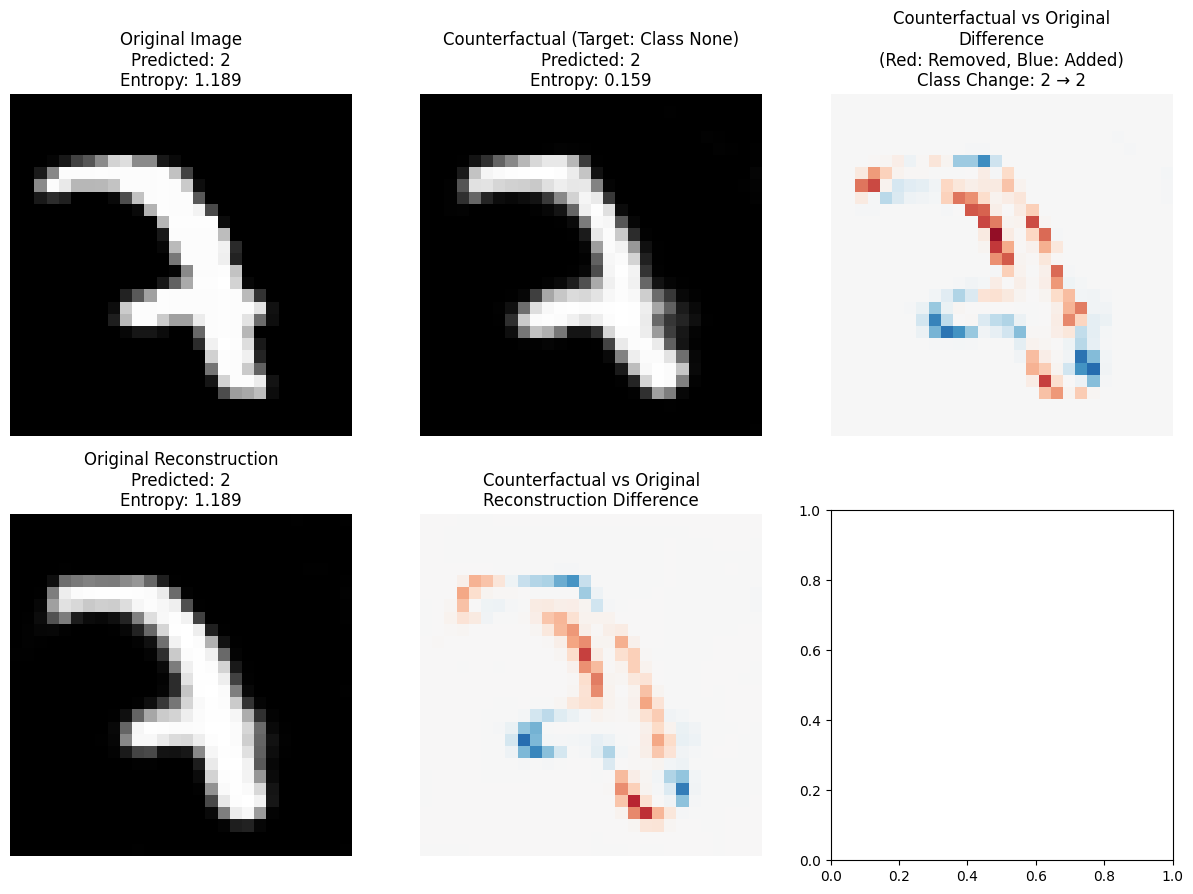

In [24]:
results, figure = evaluate_single_clue_counterfactual(
    uncertain_images[49],
    bll_vi,
    decoder,
    vae,
    device=cfg.device,
    verbose=True,
    steps=200,
    distance_weight=0.005,
    lr=0.05
)